# Examiner Monitor

This notebook shows how patent_client can be used to examine what is on a particular examiner's docket, and some simple statistics for a particular examiner.

The input to this will just be an application that we know the examiner is handling - like for example a case we just got an Office Action from.

In [1]:
app_no = '16538065'

Next, we'll do our standard imports, query the USApplication object for that application, and retreive the examiner's name

In [2]:
import pandas as pd
import numpy as np
from patent_client import USApplication

app = USApplication.objects.get(app_no)
print(f'The examiner for {app.appl_id} is {app.app_exam_name} of art unit {app.app_grp_art_number}')

The examiner for 16538065 is TRAN, ANHTAI V of art unit 2168


Then, we'll go and retreive all the cases that this examiner has ever handled by searching USApplication for all applications listing the same examiner, and then populate a subset of that data into a Pandas DataFrame.

*NOTE:* Because the USApplication object is lazy, this might take a minute - patent_client is now retrieving the application data

In [3]:
exam = USApplication.objects.filter(app_exam_name=app.app_exam_name)
exam_df = (exam.values('appl_id', 'app_filing_date', 'patent_title', 'patent_number', 'app_status', 'app_status_date')
    .to_pandas()
)
exam_df.head()

,appl_id,app_filing_date,patent_title,patent_number,app_status,app_status_date
0,17077511,2020-10-22,HANDLING OUT-OF-ORDER DATA DURING STREAM PROCE...,None,Publications -- Issue Fee Payment Verified,2022-08-11
1,16648169,2020-03-17,PARSING REGULAR EXPRESSIONS WITH SPIKING NEURA...,None,Non Final Action Mailed,2022-08-10
2,16932252,2020-07-17,LOGICAL PARTITIONS VIA HEADER-BASED PARTITION ...,None,Notice of Allowance Mailed -- Application Rece...,2022-08-09
3,17038351,2020-09-30,SYSTEM AND METHOD FOR BLOOM FILTERS IN LARGE S...,None,Notice of Allowance Mailed -- Application Rece...,2022-08-08
4,16538065,2019-08-12,SYSTEMS AND METHODS FOR ANALYZING THE VALIDITY...,None,Advisory Action Mailed,2022-08-08


## Simple Lookups

Now that we have all the Examiner's cases, we want to take a peek at what the Examiner is working on. To do that, we'll make a list of application status names that we're interested in - those that indicate that the Examiner is still working on the case and the case isn't abandoned, allowed, or awaiting a first office action

In [4]:
active_pros_statuses = [
    'Advisory Action Mailed',
    'Board of Appeals Decision Rendered',
    'Non Final Action Mailed',
    'Response after Final Action Forwarded to Examiner',
    'Response to Non-Final Office Action Entered and Forwarded to Examiner',
    'Final Rejection Mailed',
]

active_df = exam_df[exam_df['app_status'].isin(active_pros_statuses)]
active_df.head()

,appl_id,app_filing_date,patent_title,patent_number,app_status,app_status_date
1,16648169,2020-03-17,PARSING REGULAR EXPRESSIONS WITH SPIKING NEURA...,None,Non Final Action Mailed,2022-08-10
4,16538065,2019-08-12,SYSTEMS AND METHODS FOR ANALYZING THE VALIDITY...,None,Advisory Action Mailed,2022-08-08
5,16985917,2020-08-05,SYSTEM FOR AUTOMATED MATERIAL MASTER DATA HARM...,None,Response to Non-Final Office Action Entered an...,2022-08-05
6,16796106,2020-02-20,SYSTEMS AND METHODS FOR PREDICTING WHERE CONVE...,None,Final Rejection Mailed,2022-08-04
7,17158895,2021-01-26,DECLARATIVE SEGMENT ATTRIBUTE ACTIVATION,None,Final Rejection Mailed,2022-08-04


Maybe we're trying to predict when an Examiner might get to a particular case. To do that, we can use a Pandas filter to select all the cases that have the status "Docketed New Case - Ready for Examination"

In [5]:
docket_df = exam_df[exam_df['app_status'] == 'Docketed New Case - Ready for Examination']
docket_df.head()

,appl_id,app_filing_date,patent_title,patent_number,app_status,app_status_date
132,17362419,2021-06-29,METHODS AND APPARATUS TO ESTIMATE CARDINALITY ...,None,Docketed New Case - Ready for Examination,2021-08-24


Then we can use a simple function to count how many cases are ahead of ours, first by sorting by filing date, then counting how many cases down our application is:

In [6]:
docket_df = docket_df.sort_values('app_filing_date', ascending=True)

counter = 0

for i, row in docket_df.iterrows():
    if row['appl_id'] == app_no:
        break
    counter += 1

print(f"There are {counter} cases ahead of {app.appl_id} on Examiner {app.app_exam_name}'s Docket")

There are 1 cases ahead of 16538065 on Examiner TRAN, ANHTAI V's Docket


## Statistical Analysis

Maybe we want some more detailed information. Things like average pendency, overall case load, etc. Let's do some of those statistics now.

First, we'll take a look at the examiner's entire docket, bucketed by years, to get a general sense for the Examiner's workflow and case dispositions. To start, we'll add a column that will classify a case as either "Patented", "Abandoned", or "Pending". To do that, we'll use the Pandas "apply" function. If the case has a patent number, we'll categorize it as "Patented." This is better than looking at status, because the case might have lapsed for failure to pay maintenace fees. Then we'll look at the status and see if the word "abandoned" appears in it. If so, we can be reasonably sure the case has been abandoned. If it doesn't fit in either category, then the case is still pending.

In [7]:
def final_disposition(row):
    row['year'] = row['app_filing_date'].year
    if row['patent_number']:
        row['final'] = 'Patented'
    elif 'abandon' in str(row['app_status']).lower():
        row['final'] = 'Abandoned'
    else:
        row['final'] = 'Pending'
    return row
        
final_df = exam_df[~exam_df['appl_id'].str.contains('PCT')].apply(final_disposition, axis=1)

final_df.head()

,appl_id,app_filing_date,patent_title,patent_number,app_status,app_status_date,year,final
0,17077511,2020-10-22,HANDLING OUT-OF-ORDER DATA DURING STREAM PROCE...,None,Publications -- Issue Fee Payment Verified,2022-08-11,2020,Pending
1,16648169,2020-03-17,PARSING REGULAR EXPRESSIONS WITH SPIKING NEURA...,None,Non Final Action Mailed,2022-08-10,2020,Pending
2,16932252,2020-07-17,LOGICAL PARTITIONS VIA HEADER-BASED PARTITION ...,None,Notice of Allowance Mailed -- Application Rece...,2022-08-09,2020,Pending
3,17038351,2020-09-30,SYSTEM AND METHOD FOR BLOOM FILTERS IN LARGE S...,None,Notice of Allowance Mailed -- Application Rece...,2022-08-08,2020,Pending
4,16538065,2019-08-12,SYSTEMS AND METHODS FOR ANALYZING THE VALIDITY...,None,Advisory Action Mailed,2022-08-08,2019,Pending


Now we need to transform the Pandas dataframe into something we can plot. What we would like to have is a dataframe that looks like this:

| Year | Pending | Patented | Expired |
|------|---------|----------|---------|
| 2015 | 13      | 12       | 1       |
| 2016 | 14      | 15       | 15      |

To do that, we're going to need to do an aggregation by year

In [8]:
%matplotlib inline

def patented(series):
    return len(list(filter(lambda x: x == '')))

# Group by year, and by final, then create a count of each
result = final_df.groupby(['year', 'final']).agg({'final': 'count'}).rename(columns={'final': 'count'})
result = result.reset_index() # Convert indexes into columns
result = result.pivot(index='year', columns='final', values='count')

result.head()

final,Abandoned,Patented,Pending
year,,,
2003,NaN,1.0,NaN
2004,NaN,3.0,NaN
2005,11.0,20.0,NaN
2006,17.0,28.0,NaN
2007,18.0,21.0,NaN


And now we plot it!

<AxesSubplot:xlabel='year'>

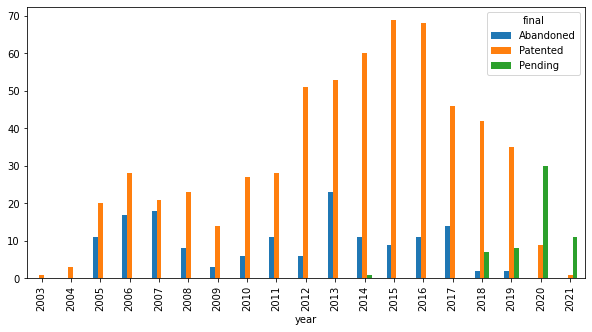

In [9]:
result.plot.bar(figsize=(10,5))

### Average Time to First Action

Maybe we'd like to know how long the Examiner takes from docketing until a first Office Action. To do that, we'll use the transaction information stored on each case. For example, from our original app, the transactions look like this:

In [10]:
app.transactions.to_pandas().head()

,code,date,description
0,BRCE,2022-08-10,Workflow - Request for RCE - Begin
1,EML_NTR,2022-08-10,Email Notification
2,MCTAV,2022-08-10,Mail Advisory Action (PTOL - 303)
3,CTAV,2022-08-05,Advisory Action (PTOL-303)
4,FWDX,2022-08-05,Date Forwarded to Examiner


First, we need to know all the possible transaction codes. To do that, we can take every case in the examiner's stack, and create a set of code-description tuples

In [11]:
codes_df = (exam
            .values("transactions")
            .explode("transactions")
            .unpack("transactions")
            .values("transactions.code", "transactions.description")
            .to_pandas()
            .drop_duplicates()
           )
codes_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 0 to 0
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   transactions.code         0 non-null      object
 1   transactions.description  0 non-null      object
dtypes: object(2)
memory usage: 24.0+ bytes


In [12]:
codes_df.head()

,transactions.code,transactions.description
0,None,None


Obviously there are entirely too many possible codes / descriptions to easily pick through in a notebook, so we'll export the spreadsheet to excel for review

In [13]:
codes_df.to_excel('codes.xlsx')

After review, it looks like all the relevant codes for a first action by the examiner begin one one of three prefixes - MFA, CT, or MC. And the case is initially docketed with a code 'DOCK'. So let's use this to calculate a time to first office action for each case. First, we'll make a dataframe that has every transaction, with the associated application id

In [14]:
app_df = pd.DataFrame.from_records({'appl_id': a.appl_id, 'obj': a} for a in examiners_applications if 'PCT' not in a.appl_id)
app_df.head()

NameError: name 'examiners_applications' is not defined

In [ ]:
transactions_df = (exam
                   .values("appl_id", "transactions")
                   .explode("transactions")
                   .unpack("transactions", prefix=False)
                   .to_pandas()
                  )
transactions_df.head()

Now we'll write a function that takes an application, and returns the time to first Examiner's action, measured as days from DOCK to an action by the examiner

In [ ]:
import re
from datetime import datetime
import warnings

first_action_re='^(MFA|CT[^SH]|MC)'

def time_to_action(group):
    transactions = group.sort_values("date")
    docketing_date = transactions.query("code == 'DOCK'").iloc[0].date
    try:
        first_action = transactions[transactions.code.str.contains(first_action_re)].iloc[0]
    except IndexError:
        return pd.Series()
    row = pd.Series()
    row['first_action'] = first_action.description
    row['first_action_code'] = first_action.code
    row['first_action_date'] = first_action.date
    row['docketed_date'] = docketing_date
    
    row['time_to_action'] = (
        first_action.date
        - docketing_date
    ).days
    return row


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    result_df = transactions_df.groupby("appl_id").apply(time_to_action).unstack()
    
result_df.head(20)

And now we can look at the aggregate stats for time to first office action:

In [ ]:
result_df.time_to_action.describe()

We can also look at the average time by what the response type is:

In [ ]:
result_df.groupby('first_action').describe()